In [6]:
import sys 
import os 
import numpy as np
import torch

sys.path.append('../')

In [7]:
from src.utils.quantizer import Normalizer
from src.linear_compress import LinearQuantizedSparse

/home/lliu/anaconda3/lib/python3.11/site-packages/torch/jit/annotations.py:389: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn(


In [8]:
import glob

In [9]:
path = "/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/"
layer_names = [name.replace(".pt","").replace(path, "") for name in glob.glob(path + "*/*.pt")]
layer_names

['layer_3/mlp.gate_proj',
 'layer_3/mlp.up_proj',
 'layer_3/self_attn.q_proj',
 'layer_3/self_attn.k_proj',
 'layer_3/self_attn.o_proj',
 'layer_3/mlp.down_proj',
 'layer_3/self_attn.v_proj',
 'layer_5/mlp.gate_proj',
 'layer_5/mlp.up_proj',
 'layer_5/self_attn.q_proj',
 'layer_5/self_attn.k_proj',
 'layer_5/self_attn.o_proj',
 'layer_5/mlp.down_proj',
 'layer_5/self_attn.v_proj',
 'layer_8/mlp.gate_proj',
 'layer_8/mlp.up_proj',
 'layer_8/self_attn.q_proj',
 'layer_8/self_attn.k_proj',
 'layer_8/self_attn.o_proj',
 'layer_8/mlp.down_proj',
 'layer_8/self_attn.v_proj',
 'layer_12/mlp.gate_proj',
 'layer_12/mlp.up_proj',
 'layer_12/self_attn.q_proj',
 'layer_12/self_attn.k_proj',
 'layer_12/self_attn.o_proj',
 'layer_12/mlp.down_proj',
 'layer_12/self_attn.v_proj',
 'layer_1/mlp.gate_proj',
 'layer_1/mlp.up_proj',
 'layer_1/self_attn.q_proj',
 'layer_1/self_attn.k_proj',
 'layer_1/self_attn.o_proj',
 'layer_1/mlp.down_proj',
 'layer_1/self_attn.v_proj',
 'layer_7/mlp.gate_proj',
 'layer

In [21]:
# linear_layer = "layer_1/mlp.up_proj"
import tqdm

device = "cuda:0"

correlation_with_wanda_no_group = []
correlation_with_wanda_group = []

with torch.no_grad():
    for linear_layer in tqdm.tqdm(layer_names):
        weight = f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/{linear_layer}.pt"
        hessian = f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/hessians_new/seed_0/pajama/128/{linear_layer}.pt"

        weight = torch.load(weight, map_location=device)["weight"]
        hessian = torch.load(hessian, map_location=device)["hessian"]
        wanda_sparse_no_group = LinearQuantizedSparse(weight)
        wanda_sparse_no_group.hessian = hessian.clone()
        wanda_sparse_no_group.sparse_only(["wanda"], 0.5, sparse_after_norm=False, pattern=None)
        wanda_no_group_mask = wanda_sparse_no_group.sparse_modules[0].sparse_mask.clone()

        wanda_sparse_group = LinearQuantizedSparse(weight)
        wanda_sparse_group.hessian = hessian.clone()
        wanda_sparse_group.sparse_only(["wanda"], 0.5, sparse_after_norm=False, pattern=None, group="n_in")
        wanda_group_mask = wanda_sparse_group.sparse_modules[0].sparse_mask.clone()

        our_group = LinearQuantizedSparse(weight)
        our_group.hessian = hessian.clone()
        our_group.sparse_only(["wanda"], 0.5, sparse_after_norm=True, pattern=None,
                              norm_order=[0,1], zero=[True,True])
        our_mask = our_group.sparse_modules[0].sparse_mask.clone()

        wanda_no_group_mask = wanda_no_group_mask.flatten().float()
        wanda_group_mask = wanda_group_mask.flatten().float()
        our_mask = our_mask.flatten().float()

        #caclulate the correlation coefficient
        correlation_no_group = torch.corrcoef(torch.stack([wanda_no_group_mask, our_mask]))[0,1].item()
        correlation_group = torch.corrcoef(torch.stack([wanda_group_mask, our_mask]))[0,1].item()
    

        correlation_with_wanda_no_group.append(correlation_no_group)
        correlation_with_wanda_group.append(correlation_group)

  0%|          | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_1066337/530598008.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(weight, map_location=device)

In [22]:
wanda_no_group_mask

tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')

In [23]:
our_mask

tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')

In [24]:
correlation_with_wanda_no_group


[0.9325061440467834,
 0.9712319374084473,
 0.7335112690925598,
 0.6990519165992737,
 0.9201880097389221,
 0.9720377326011658,
 0.9044719338417053,
 0.9004629850387573,
 0.9651796221733093,
 0.7829015851020813,
 0.7478154301643372,
 0.9373953938484192,
 0.9648687243461609,
 0.9167144894599915,
 0.8853382468223572,
 0.960706889629364,
 0.7714839577674866,
 0.7471714615821838,
 0.9247758984565735,
 0.960813045501709,
 0.9081857800483704,
 0.8838151693344116,
 0.9548348784446716,
 0.7831526398658752,
 0.7561433911323547,
 0.9198082089424133,
 0.9559904336929321,
 0.9089980721473694,
 0.914480984210968,
 0.9697145819664001,
 0.658917248249054,
 0.7022467255592346,
 0.8339293599128723,
 0.9740371108055115,
 0.7437410950660706,
 0.8813508749008179,
 0.9638810753822327,
 0.7544344067573547,
 0.736373245716095,
 0.891473114490509,
 0.9635947346687317,
 0.8796091675758362,
 0.9101405143737793,
 0.9511967301368713,
 0.7142594456672668,
 0.7331417202949524,
 0.8619685769081116,
 0.9661425352096558

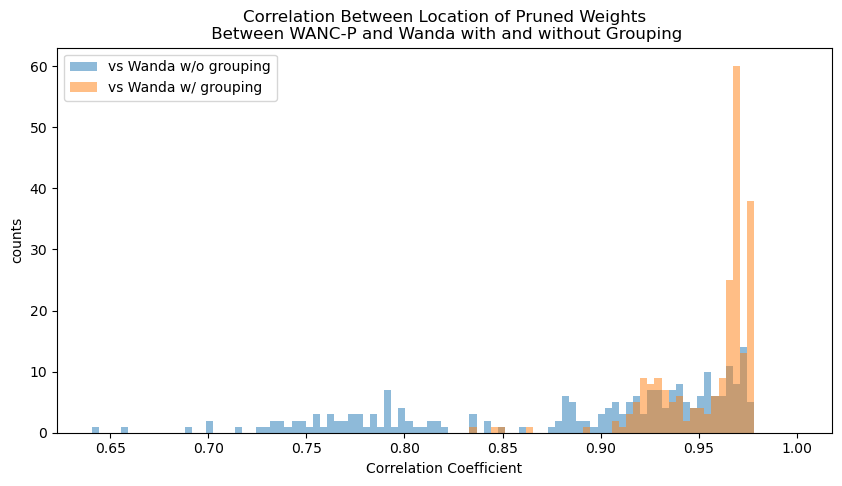

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))  
#plot out two histograms
bins = np.linspace(min(min(correlation_with_wanda_no_group), min(correlation_with_wanda_group)),1,100)
plt.hist(correlation_with_wanda_no_group, bins=bins, alpha=0.5, label=f"vs Wanda w/o grouping")
plt.hist(correlation_with_wanda_group, bins=bins, alpha=0.5, label=f"vs Wanda w/ grouping")
# plt.yscale("log")

plt.ylabel("counts")
plt.xlabel("Correlation Coefficient")
plt.legend()
plt.title("Correlation Between Location of Pruned Weights\n Between WANC-P and Wanda with and without Grouping")
plt.savefig("correlation_between_wanda_and_our_grouping.png")